In [54]:
!pip list

Package                 Version
----------------------- ------------
absl-py                 1.4.0
aiohttp                 3.9.0
aiosignal               1.2.0
arviz                   0.16.0
asttokens               2.4.1
astunparse              1.6.3
async-timeout           4.0.2
attrs                   23.1.0
blinker                 1.6.2
Bottleneck              1.3.5
Brotli                  1.0.9
cachetools              4.2.2
certifi                 2023.11.17
cffi                    1.16.0
charset-normalizer      2.0.4
click                   8.1.7
cmdstanpy               1.1.0
colorama                0.4.6
comm                    0.1.4
contourpy               1.2.0
convertdate             2.3.2
cryptography            41.0.3
cycler                  0.11.0
Cython                  3.0.0
debugpy                 1.8.0
decorator               5.1.1
ephem                   4.1.2
exceptiongroup          1.2.0
executing               2.0.1
flatbuffers             2.0
fonttools              

## 数据分析与清洗

In [55]:
import numpy as np
import pandas as pd 

from datetime import datetime, date 

import seaborn as sns
import matplotlib.pyplot as plt 
from colorama import Fore

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import math

import warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

In [56]:
df = pd.read_csv("Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [57]:
# 去掉Rainfall_Bastia_Umbra	为NA的行
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [58]:
#修改列名更清晰
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']
#确定预测目标为地下水位
targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()
features

['date', 'rainfall', 'temperature', 'drainage_volume', 'river_hydrometry']

In [59]:
#将日期转换为时间格式
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


In [60]:
#处理缺失值
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

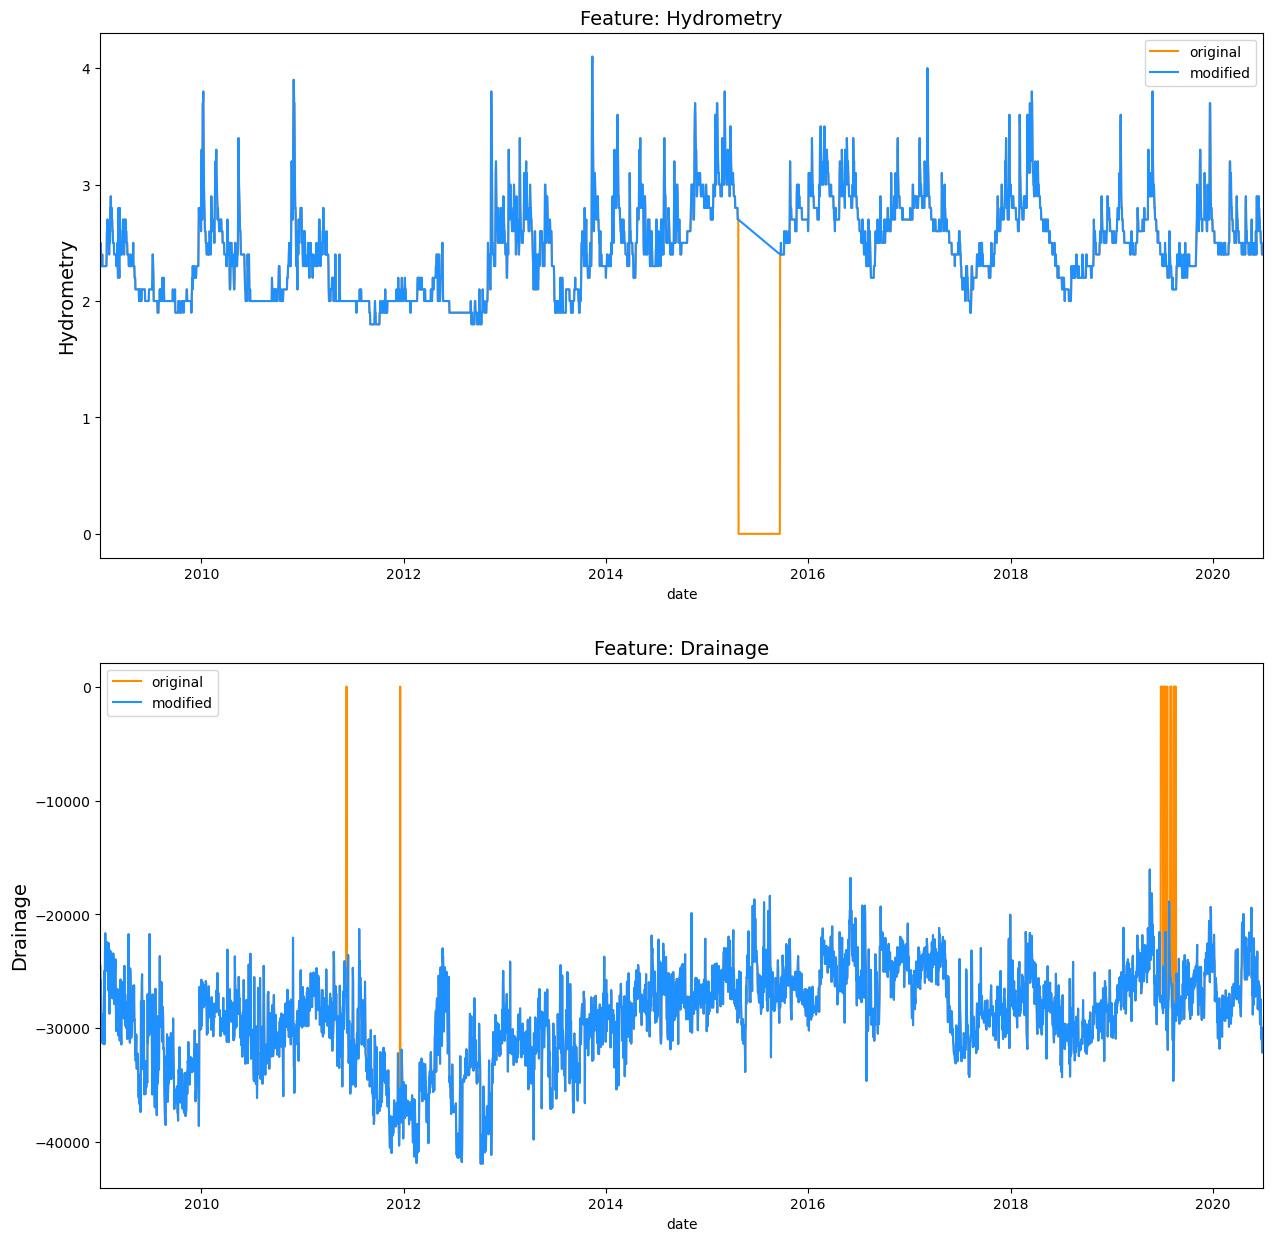

In [61]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

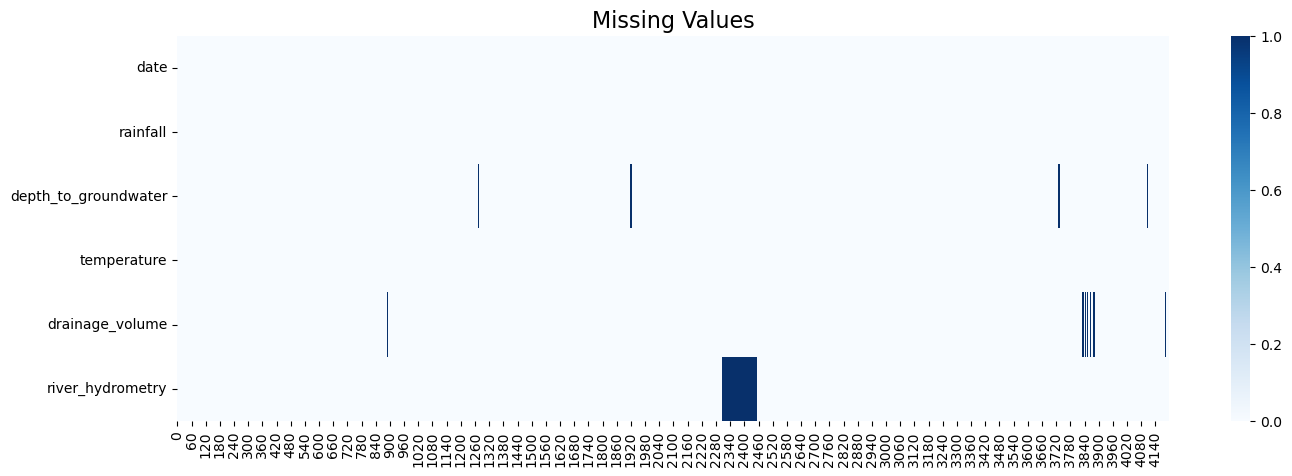

In [62]:

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)
#查看缺失值
plt.show()

In [63]:
#采用插值填补的方法补上na值

df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

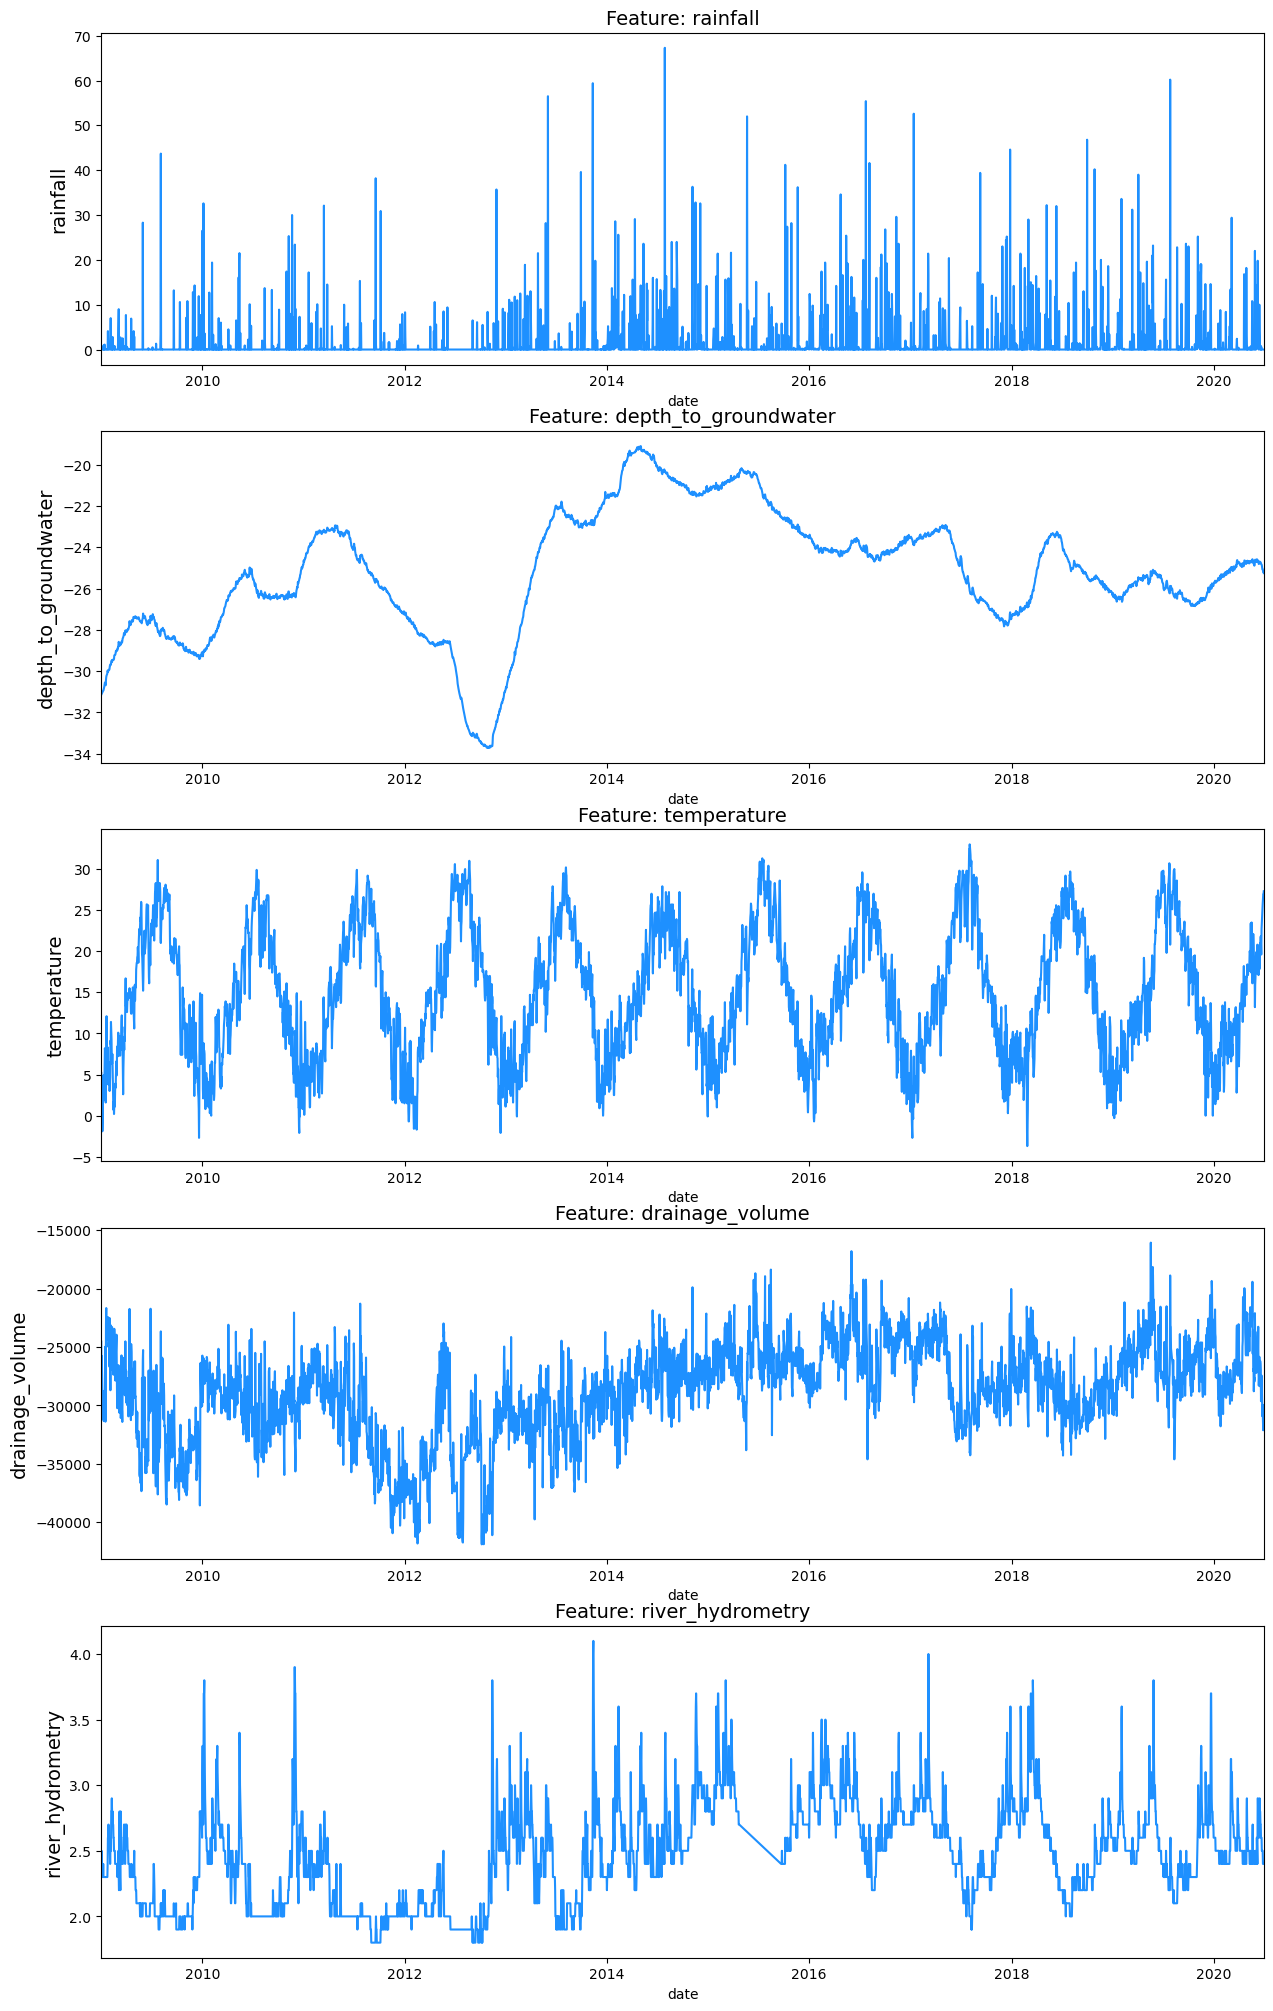

In [64]:
#做出填补后的图
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])      

使用原始的以天为间隔的数据，其波动较大，噪声占比过多，进行拟合更容易出现过拟合的现象，考虑使用周，或月作为时间刻度进行平滑

In [65]:
class smooth():
    def __init__(self,var_name,color):
        self.node=var_name
        self.col=color
    def draw(self):
        fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(16,12))
        
        sns.lineplot(x=df['date'], y=df[self.node], color=self.col, ax=ax[ 0])
        ax[0].set_title(''+self.node, fontsize=14)

        resampled_df = df[['date',self.node]].resample('7D', on='date').sum().reset_index(drop=False)
        sns.lineplot(x=resampled_df['date'], y=resampled_df[self.node], color=self.col, ax=ax[1])
        ax[1].set_title('Weekly '+self.node, fontsize=14)

        resampled_df = df[['date',self.node]].resample('M', on='date').sum().reset_index(drop=False)
        sns.lineplot(x=resampled_df['date'], y=resampled_df[self.node], color=self.col, ax=ax[2])
        ax[2].set_title('Monthly '+self.node, fontsize=14)

        for i in range(3):
            ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

In [66]:
list(df.columns)

['date',
 'rainfall',
 'depth_to_groundwater',
 'temperature',
 'drainage_volume',
 'river_hydrometry']

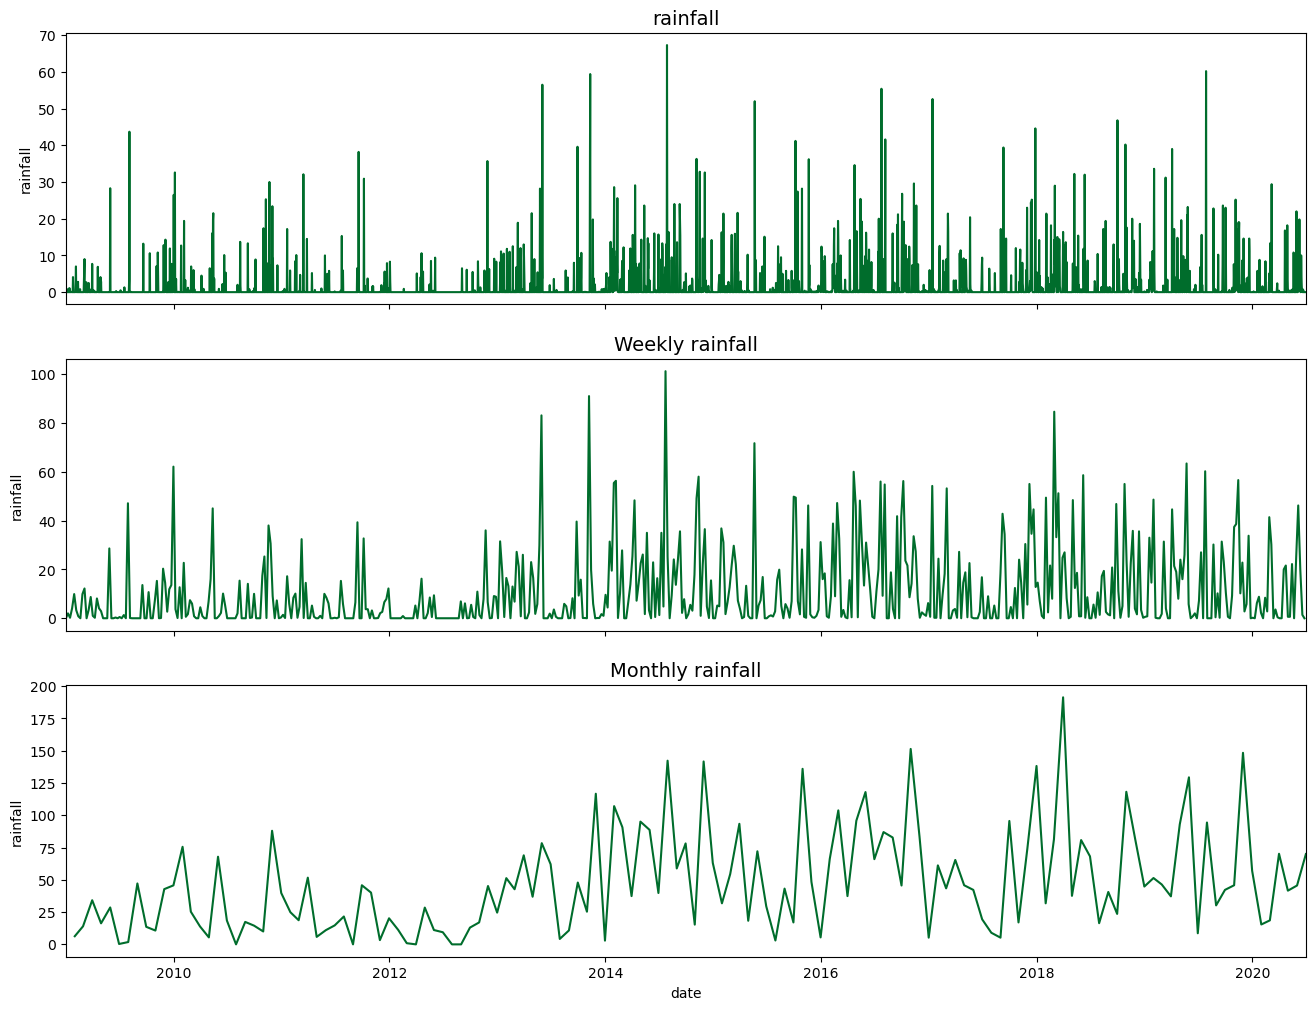

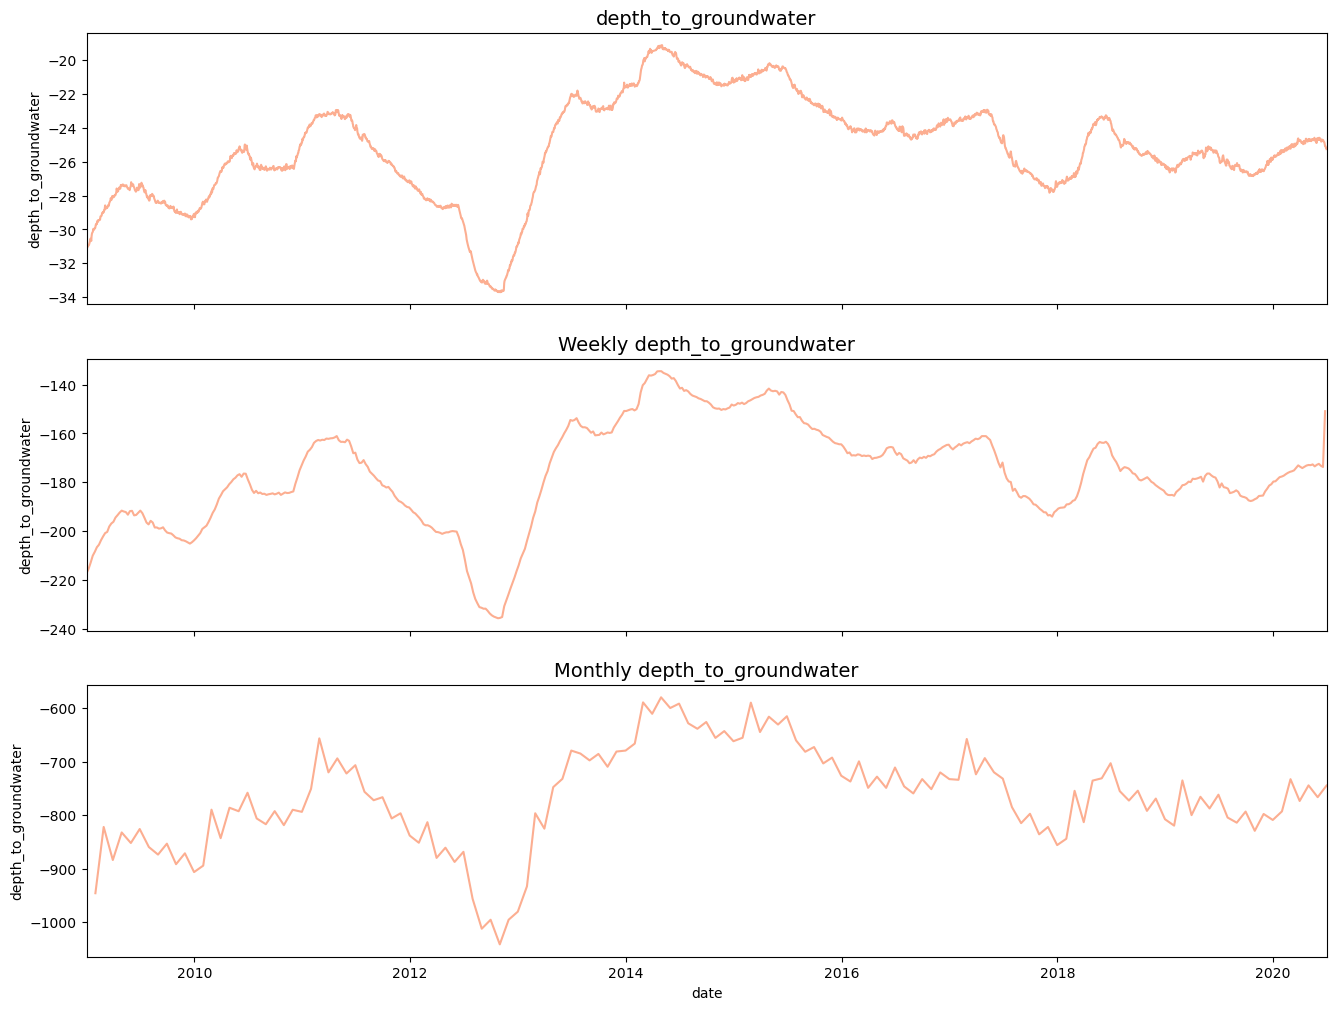

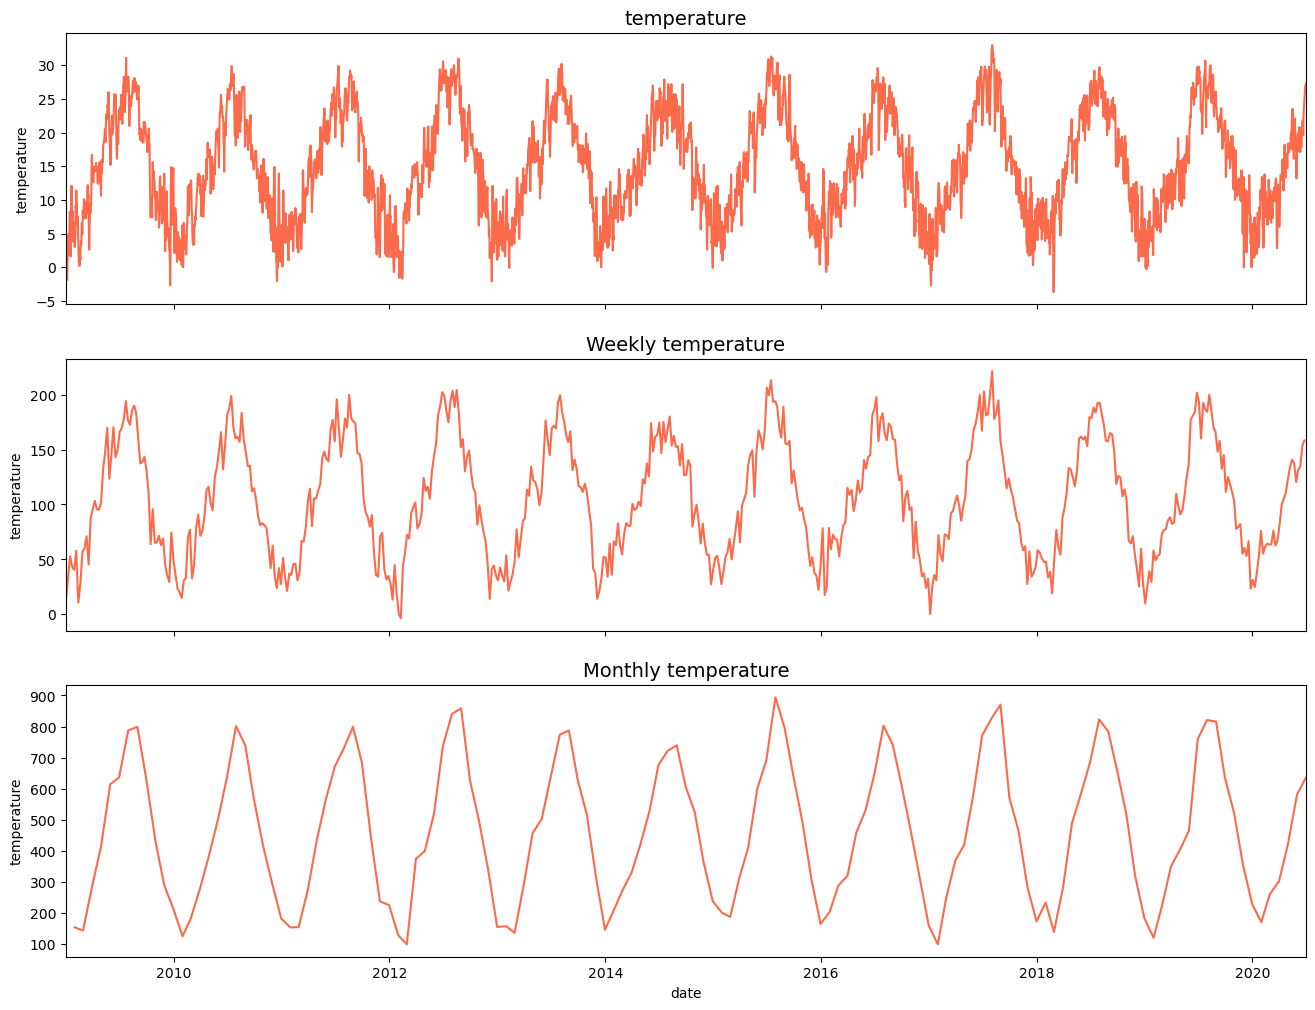

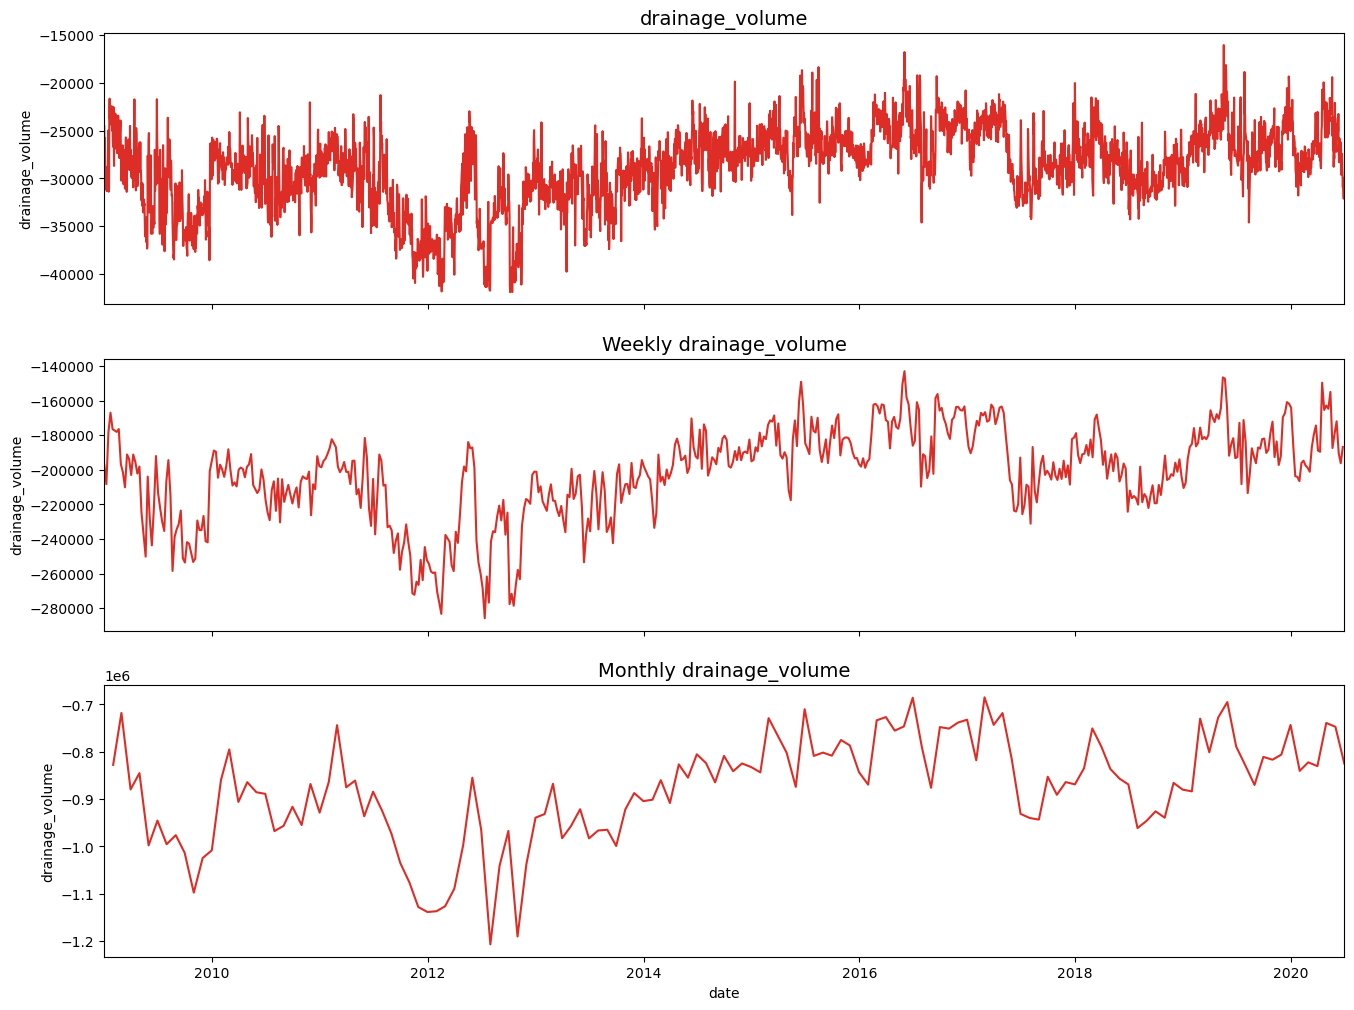

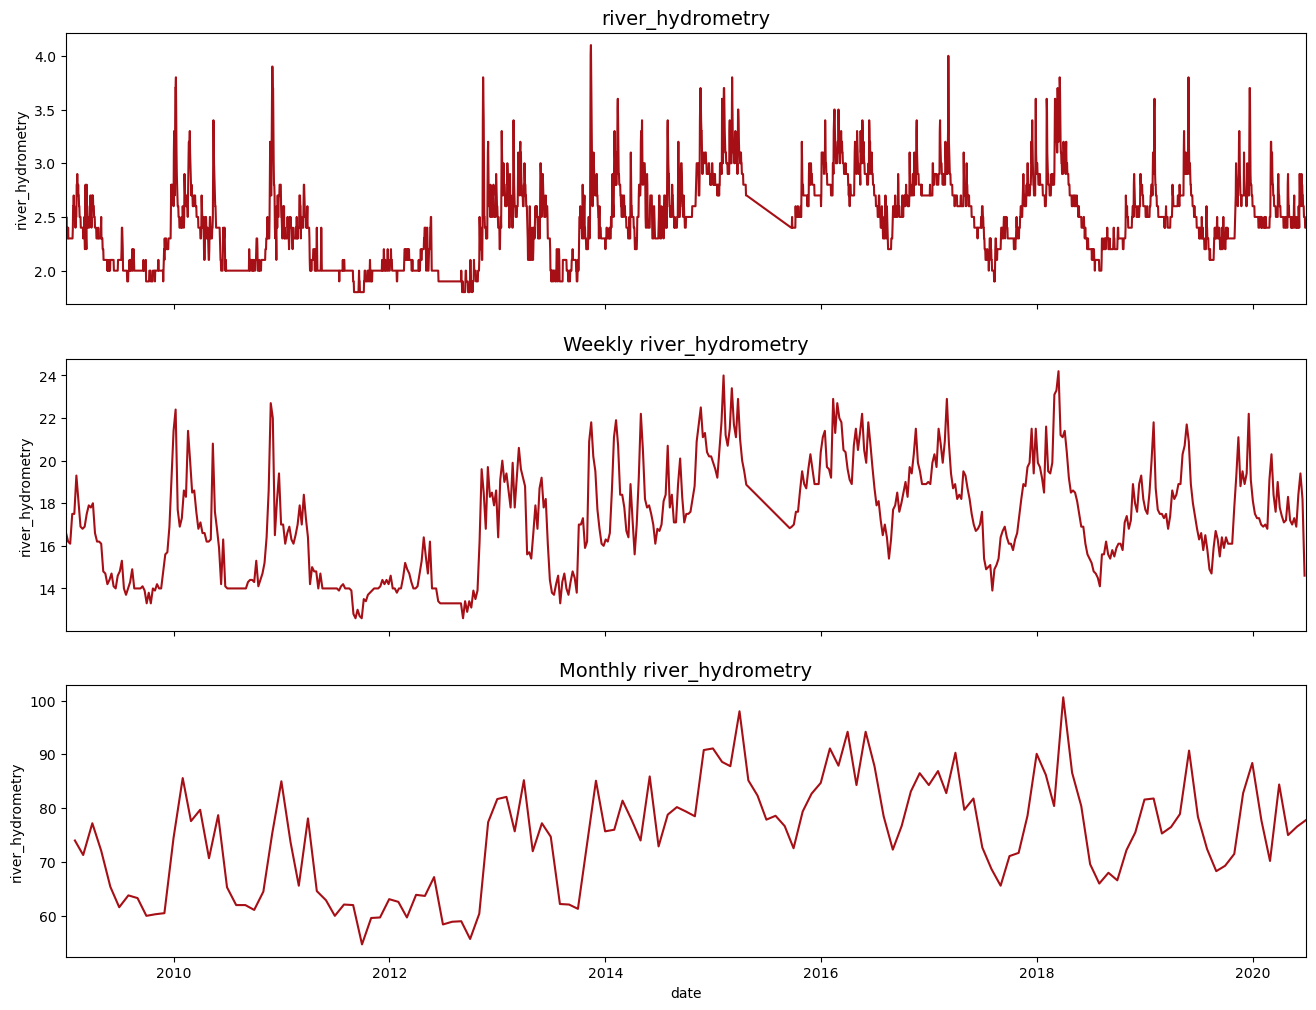

In [67]:
col=['#006d2c',
'#fcae91',
'#fb6a4a',
'#de2d26',
'#a50f15']

for i in range(1,6):
    node=list(df.columns)[i]
    color=col[i-1]
    smooth(node,color).draw()

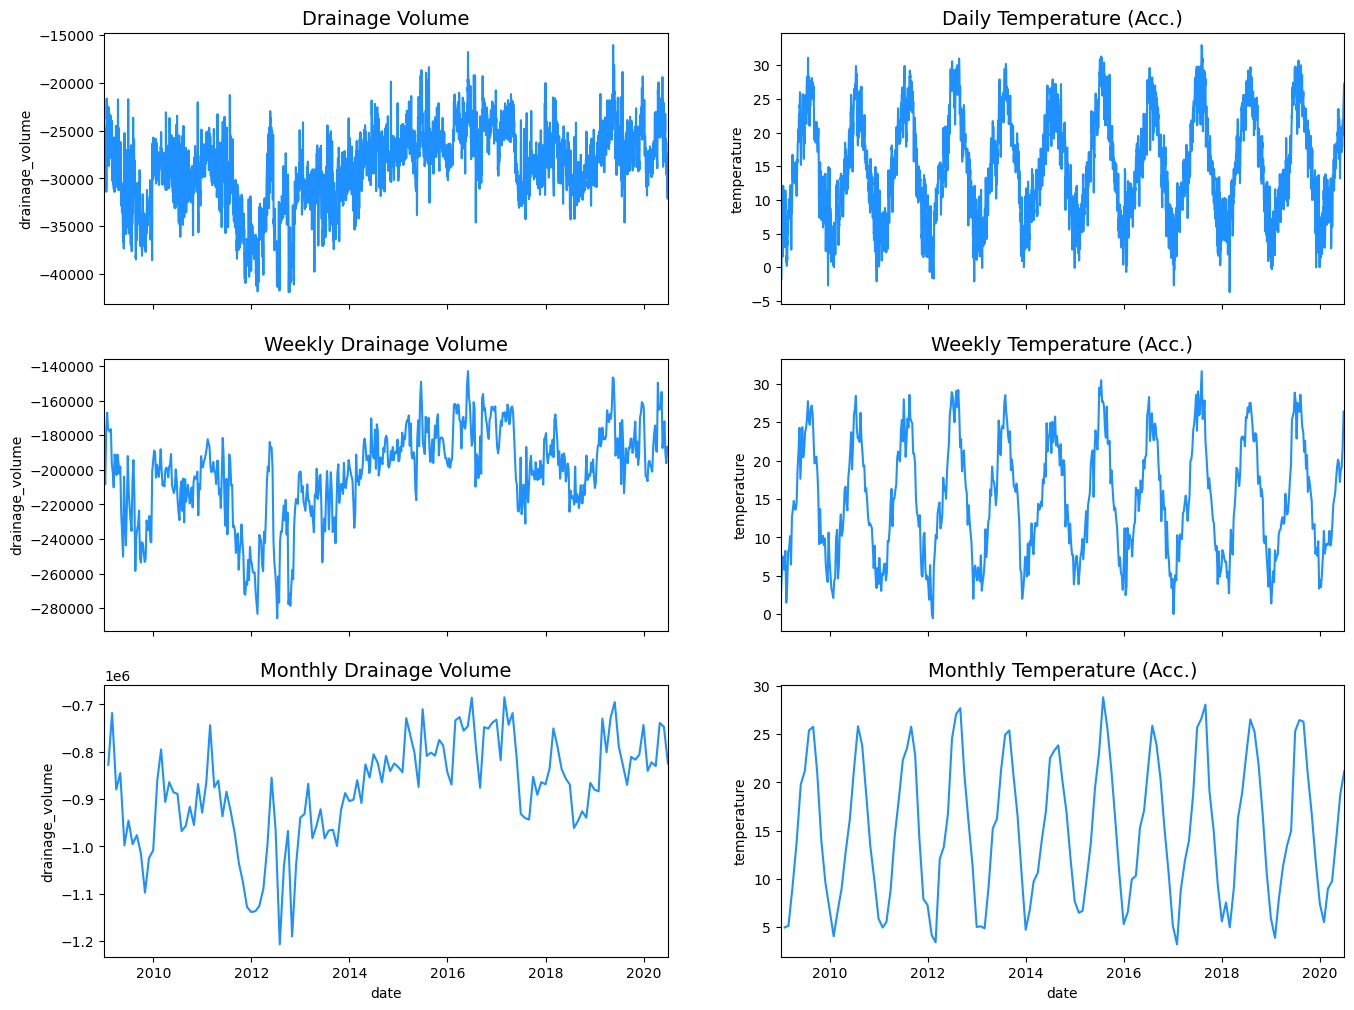

In [68]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

根据图片，此处选取以周为单位

In [69]:
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

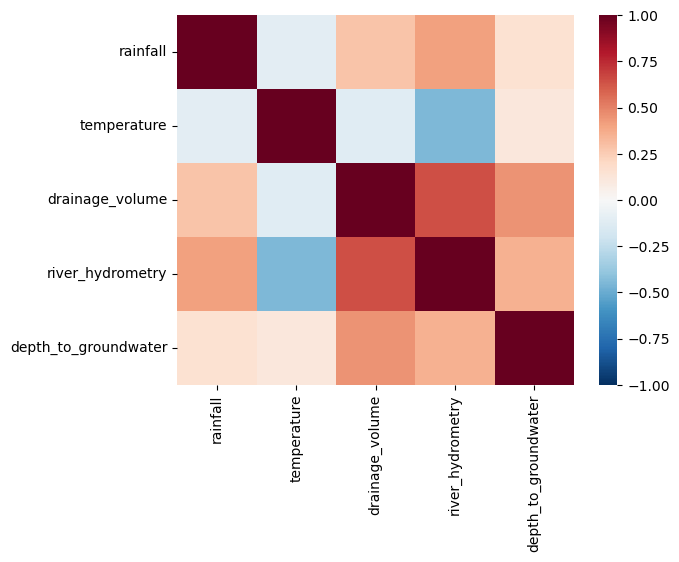

,rainfall,temperature,drainage_volume,river_hydrometry,depth_to_groundwater
rainfall,1.000000,-0.103933,0.288474,0.408361,0.148775
temperature,-0.103933,1.000000,-0.124923,-0.448803,0.115366
drainage_volume,0.288474,-0.124923,1.000000,0.643402,0.452743
river_hydrometry,0.408361,-0.448803,0.643402,1.000000,0.354382
depth_to_groundwater,0.148775,0.115366,0.452743,0.354382,1.000000


In [70]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]



corrmat = df[core_columns].corr()

sns.heatmap(corrmat,  vmin=-1, vmax=1, cmap="RdBu_r")


plt.show()

corrmat

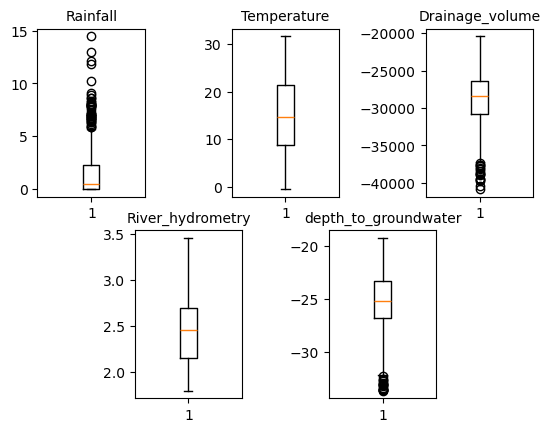

In [71]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 6)
gs.update(wspace=8)
ax1 = plt.subplot(gs[0, :2])
ax1.boxplot(df['rainfall'])
ax1.set_title('Rainfall', fontsize=10)

ax2 = plt.subplot(gs[0, 2:4])
ax2.boxplot(df['temperature'])
ax2.set_title('Temperature', fontsize=10)

ax3 = plt.subplot(gs[0, 4:6])
ax3.boxplot(df['drainage_volume'])
ax3.set_title('Drainage_volume', fontsize=10)

ax4 = plt.subplot(gs[1, 1:3])
ax4.boxplot(df['river_hydrometry'])
ax4.set_title('River_hydrometry', fontsize=10)

ax5 = plt.subplot(gs[1, 3:5])
ax5.boxplot(df['depth_to_groundwater'])
ax5.set_title('depth_to_groundwater', fontsize=10)
plt.show()


Text(0.5, 1.0, 'depth_to_groundwater')

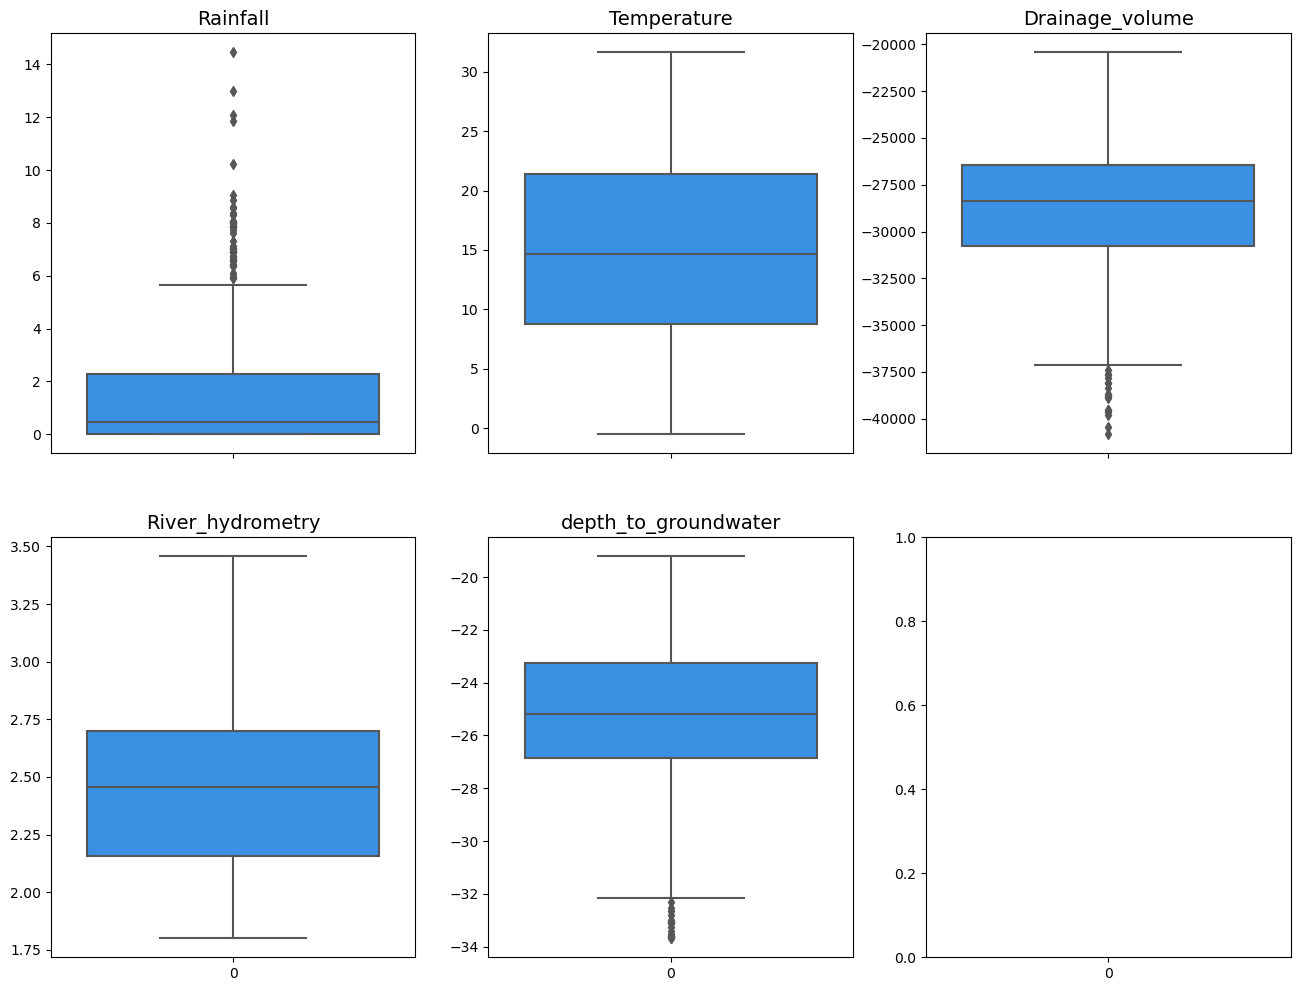

In [72]:


fig, ax = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(16,12))

sns.boxplot(df['rainfall'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Rainfall', fontsize=14)

sns.boxplot(df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Temperature', fontsize=14)

sns.boxplot(df['drainage_volume'], color='dodgerblue', ax=ax[0, 2])
ax[0, 2].set_title('Drainage_volume', fontsize=14)

sns.boxplot(df['river_hydrometry'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('River_hydrometry', fontsize=14)

sns.boxplot(df['depth_to_groundwater'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('depth_to_groundwater', fontsize=14)

#sns.boxplot(df['drainage_volume'], color='dodgerblue', ax=ax[1, 2])
#ax[1, 2].set_title('Drainage_volume', fontsize=14)

## 检验平稳性

采用ADF检验

In [73]:
result = adfuller(df['depth_to_groundwater'].values)
result

#p>0.01 不平稳

(-2.8802016493166653,
 0.04769919092020824,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

In [74]:
#一阶差分
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

In [75]:
result = adfuller(df['depth_to_groundwater_diff_1'].values)
result

(-5.149643828792041,
 1.1130396636935197e-05,
 6,
 593,
 {'1%': -3.4414256033746606,
  '5%': -2.8664262627821473,
  '10%': -2.569372254520843},
 -727.8013806521367)

In [76]:
df.head()

,date,depth_to_groundwater,temperature,drainage_volume,river_hydrometry,rainfall,depth_to_groundwater_diff_1
0,2009-01-01,-31.048571,1.657143,-28164.918857,2.371429,0.000000,0.000000
1,2009-01-08,-30.784286,4.571429,-29755.789714,2.314286,0.285714,0.264286
2,2009-01-15,-30.420000,7.528571,-25463.190857,2.300000,0.028571,0.364286
3,2009-01-22,-30.018571,6.214286,-23854.422857,2.500000,0.585714,0.401429
4,2009-01-29,-29.790000,5.771429,-25210.532571,2.500000,1.414286,0.228571


# 模型的建立

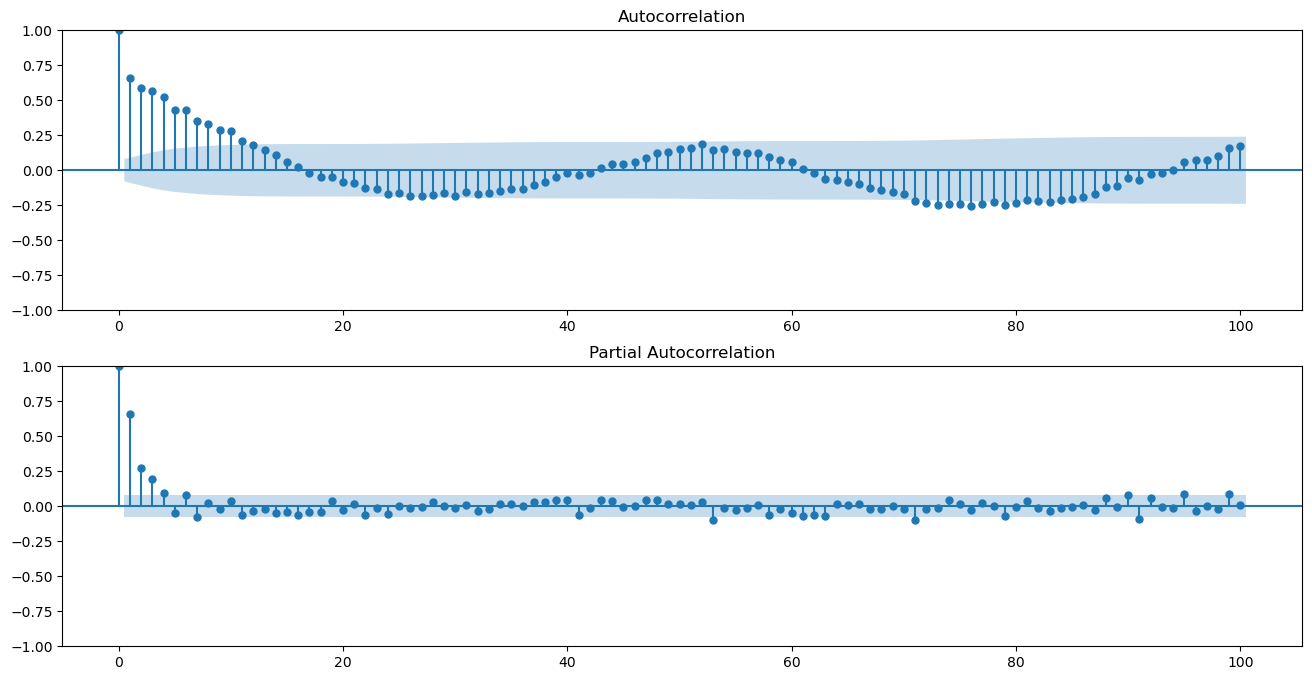

In [77]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

In [78]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


In [79]:
#采用auto的方法选择变量
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.350, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [80]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

y_pred=model_fit.forecast(90)

y_pred_ARIMA=y_pred

In [81]:
# 计算RMSE
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.4026393405170363


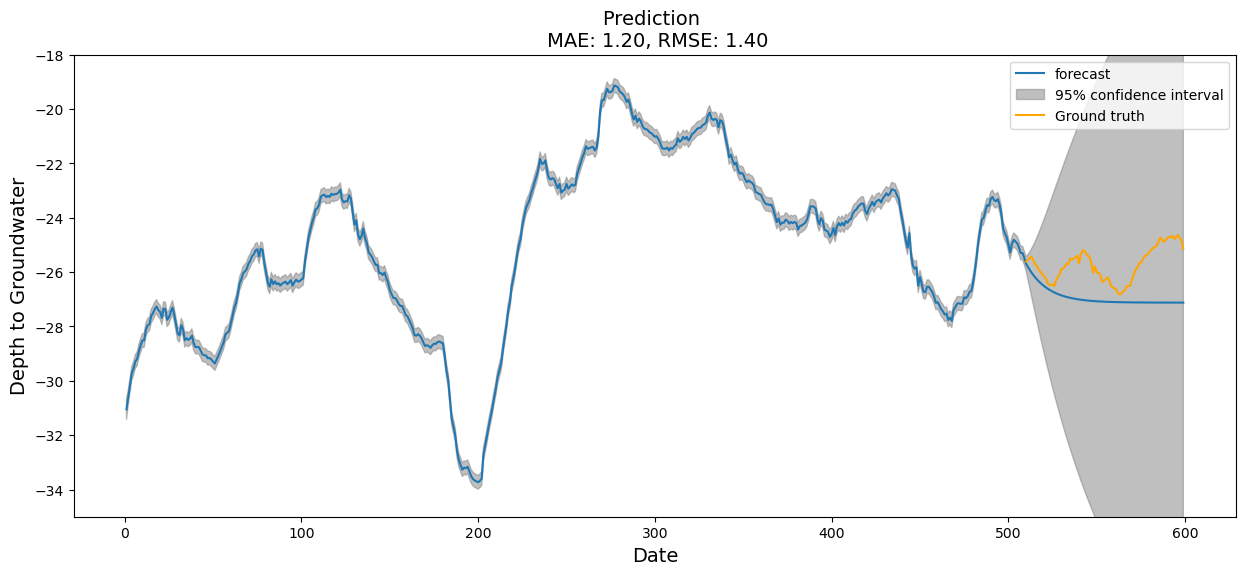

In [82]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

plot_predict(model_fit, 1, 599, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') 

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

ax.set_ylim(-35, -18)
plt.show()

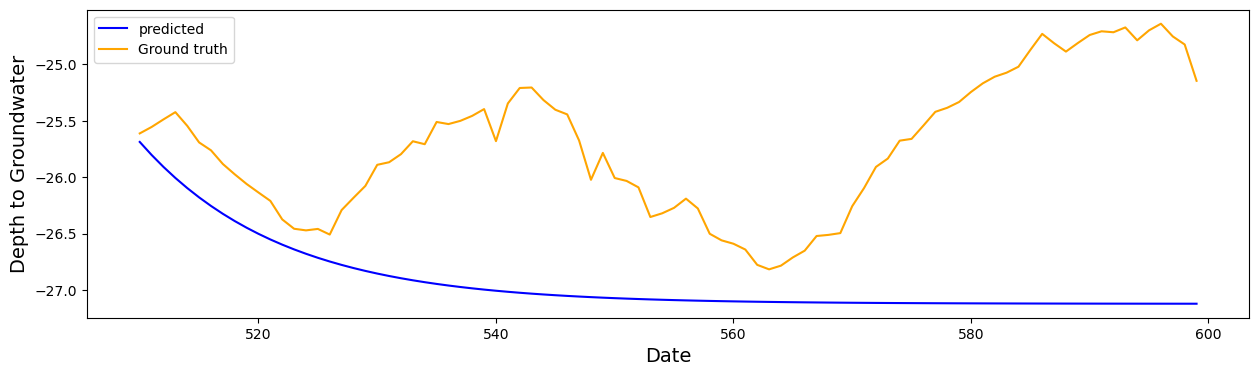

In [83]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

## 线性回归

In [84]:

target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [85]:
y_train.head()

,y
0,-31.048571
1,-30.784286
2,-30.420000
3,-30.018571
4,-29.790000


In [86]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_train[feature_columns], y_train)
print(model.coef_)
print(model.intercept_)
y_pred = model.predict(x_valid[feature_columns]).flatten()
y_pred_linear=y_pred

[[-1.29071200e-02  1.18882100e-01  3.16892111e-04  2.24143120e+00]]
[-23.08906204]


In [87]:
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.988066620833229


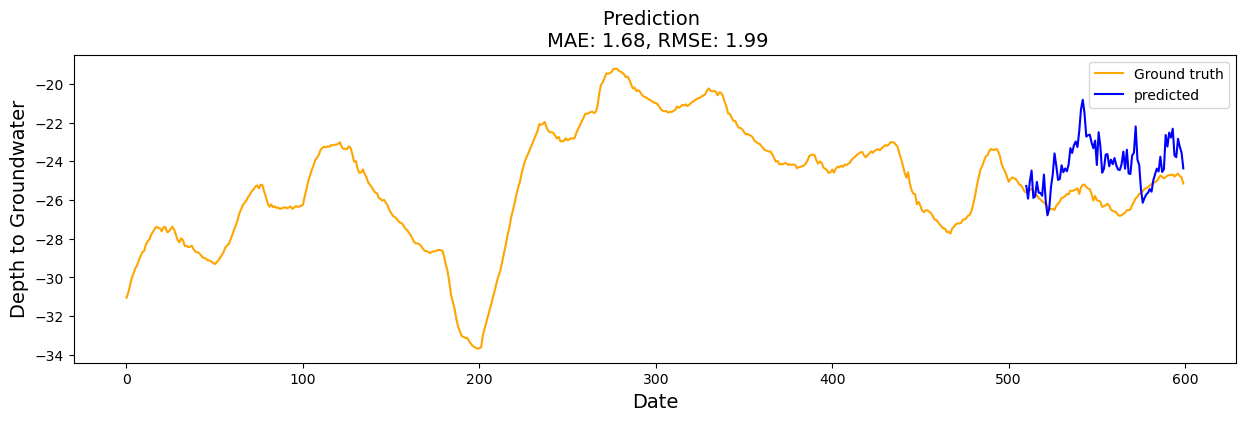

In [88]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth')
sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax, color='orange')
sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') 
ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

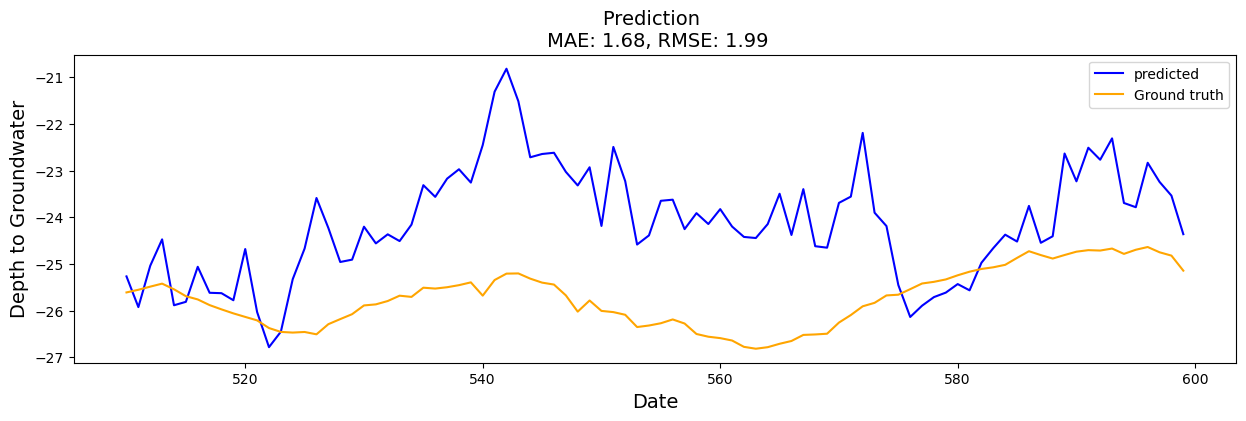

In [89]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') 
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') 

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

# 随机森林

In [90]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV


最大得分：-9.830689274473638 子树数量为：41


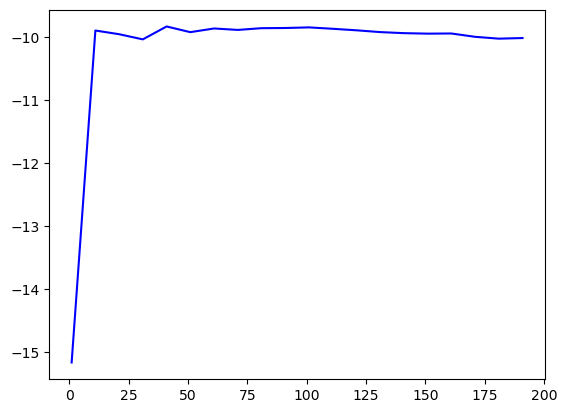

In [39]:
# 调参，绘制学习曲线来调参n_estimators
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,200,10):
    try:
        rf =RandomForestRegressor(n_estimators=i+1
                                ,random_state=90)
        score = cross_val_score(rf, x_train[feature_columns], y_train, cv=10).mean()
        score_lt.append(score)
    except:
        print("超出了范围")
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'b-')
plt.show()

最大得分：-9.830689274473638 子树数量为：41


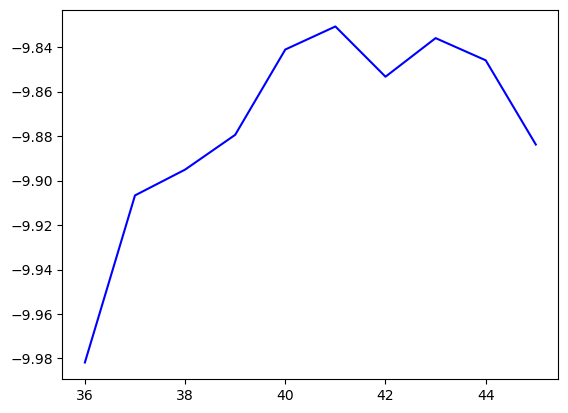

In [40]:
score_lt = []

# 寻找更精确的取值，步幅为1
for i in range(35,45,1):
    rf =RandomForestRegressor(n_estimators=i+1
                                ,random_state=90)
    score = cross_val_score(rf, x_train[feature_columns], y_train, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)+36))

# 绘制学习曲线
x = np.arange(36,46)
plt.subplot(111)
plt.plot(x, score_lt, 'b-')
plt.show()

In [41]:
# 用网格搜索调整参数
param_grid = {'max_features':np.arange(2,5),'max_depth':np.arange(3,5)}

rf = RandomForestRegressor(n_estimators=41,random_state=90)
GS = GridSearchCV(rf, param_grid, cv=10)
GS.fit(x_train[feature_columns], y_train)
best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)  

{'max_depth': 3, 'max_features': 2} -7.357281384137204


In [91]:

regressor = RandomForestRegressor(n_estimators=41,max_depth=3,max_features=2, random_state=0)
regressor.fit(x_train[feature_columns], y_train)
y_pred = regressor.predict(x_valid[feature_columns])
y_pred_forest=y_pred

feature_importances = regressor.feature_importances_

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.7332987746497128


In [94]:
#重要性作图
feature_importances
feature_columns
feature_importances_df=pd.DataFrame({'feature': feature_columns, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)
 
# 颜色映射
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_columns)))



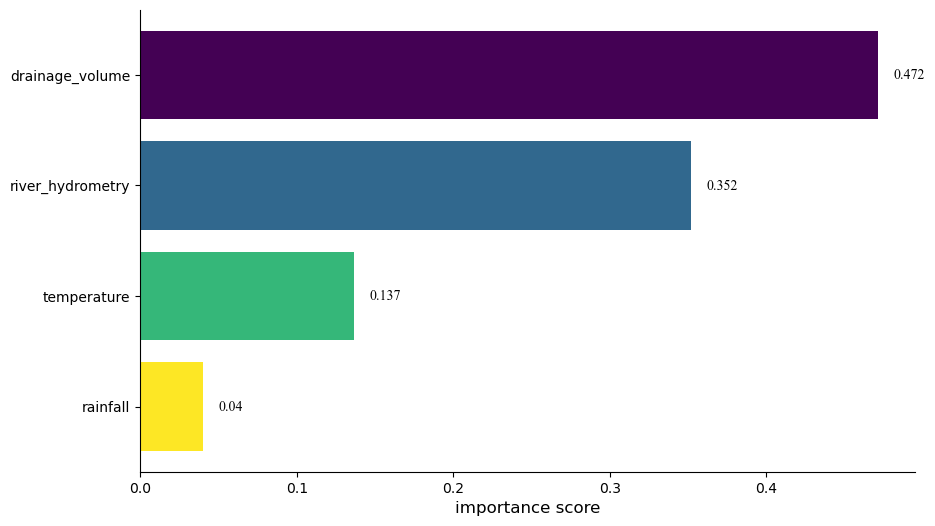

In [98]:
# 可视化特征重要性
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importances_df['feature'], feature_importances_df['importance'], color=colors)
ax.invert_yaxis()  # 翻转y轴，使得最大的特征在最上面
ax.set_xlabel('importance score', fontsize=12)  # 图形的x标签
#ax.set_title('importance of features in random foreast',fontsize=16)
for i, v in enumerate(feature_importances_df['importance']):
    ax.text(v + 0.01, i, str(round(v, 3)), va='center', fontname='Times New Roman', fontsize=10)
# 设置图形样式
# plt.style.use('default')
ax.spines['top'].set_visible(False)  # 去掉上边框
ax.spines['right'].set_visible(False)  # 去掉右边框
# ax.spines['left'].set_linewidth(0.5)#左边框粗细
# ax.spines['bottom'].set_linewidth(0.5)#下边框粗细
# ax.tick_params(width=0.5)
# ax.set_facecolor('white')#背景色为白色
# ax.grid(False)#关闭内部网格线
 

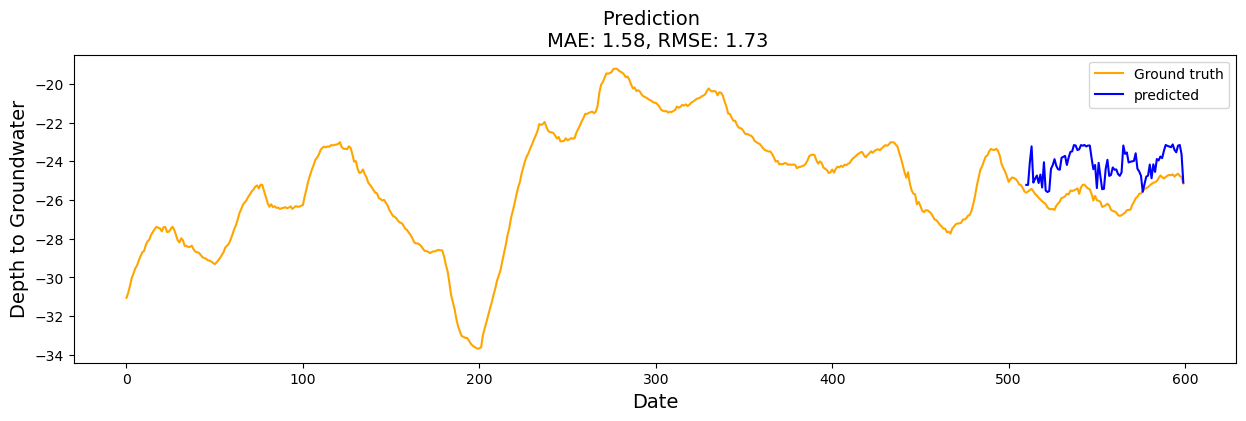

In [43]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth')
sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax, color='orange')
sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') 
ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

# 多变量时间序列模型

In [44]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [45]:
from prophet import Prophet



# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# 拟合模型
model.fit(train)

# 预测
y_pred = model.predict(x_valid)
y_pred_mul=y_pred.yhat

# 计算MAE,RMSE
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

Importing plotly failed. Interactive plots will not work.
22:13:02 - cmdstanpy - INFO - Chain [1] start processing
22:13:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.0040198249672525


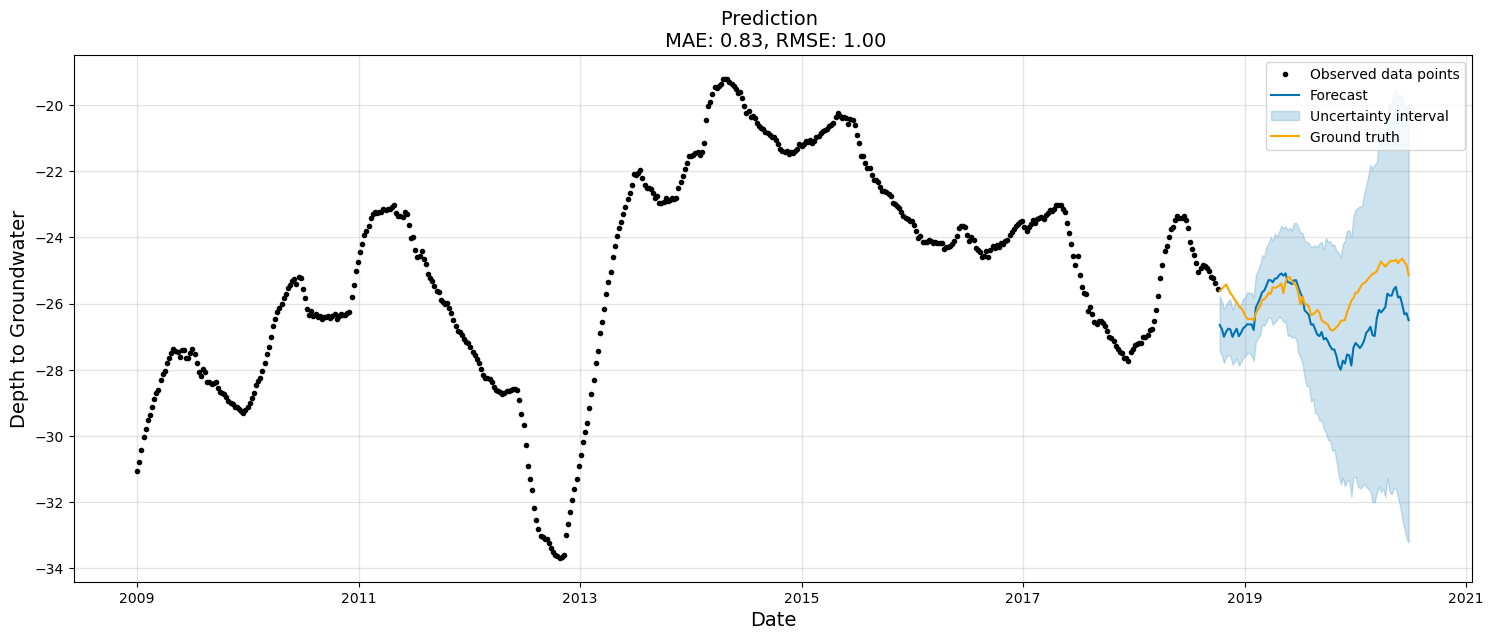

In [46]:

f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

# LSTM

In [47]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [48]:

look_back = 52
# 划分测试训练集
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)


x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [49]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#建立 LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 3s 4ms/step - loss: 0.0107 - val_loss: 5.1252e-04
Epoch 2/5
406/406 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 4/5
406/406 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 3.8190e-04
Epoch 5/5
406/406 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 6.9991e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            92672     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
           

In [50]:

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)


train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print( 'RMSE: {}'.format(score_rmse))

y_pred_lstm=test_predict[:,0]

3/3 [==============================] - 0s 2ms/step
RMSE: 0.3828548654723516


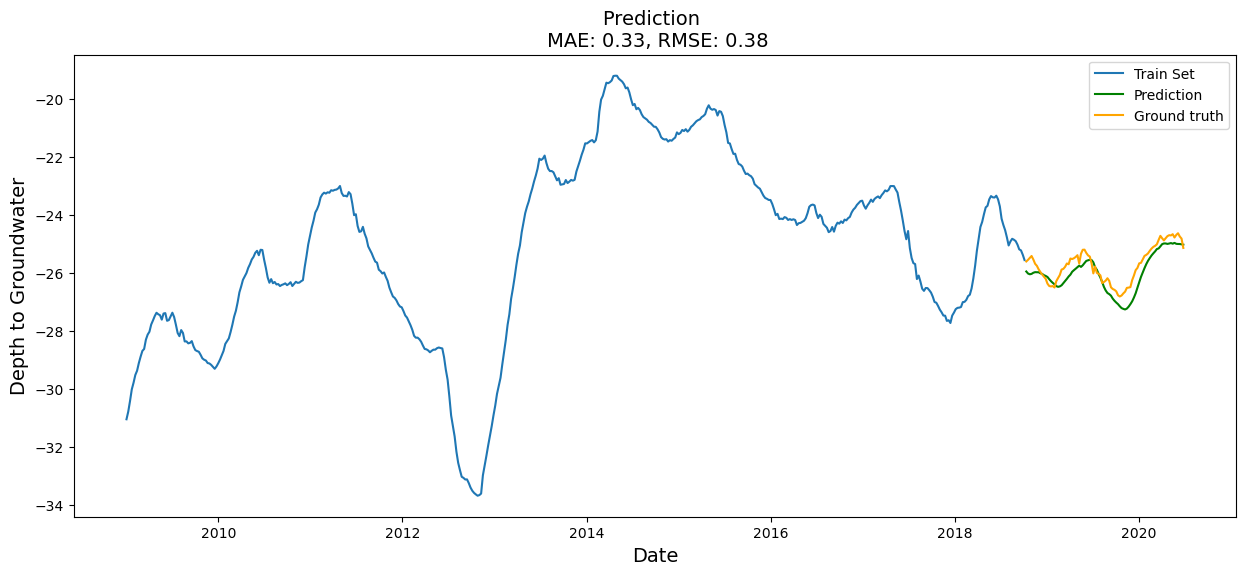

In [51]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') 
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') 
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') 

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

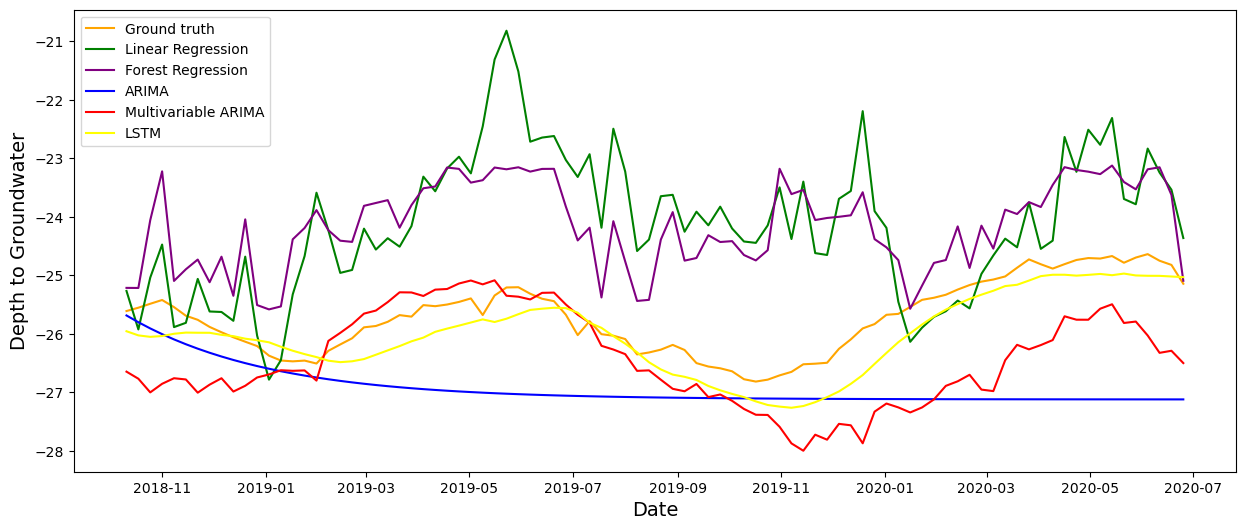

In [52]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') 

sns.lineplot(x=x_test_ticks, y=y_pred_linear, ax=ax, color='green', label='Linear Regression') 
sns.lineplot(x=x_test_ticks, y=y_pred_forest, ax=ax, color='purple', label='Forest Regression') 
sns.lineplot(x=x_test_ticks, y=y_pred_ARIMA, ax=ax, color='blue', label='ARIMA')
sns.lineplot(x=x_test_ticks, y=np.array(y_pred_mul), ax=ax, color='red', label='Multivariable ARIMA')
sns.lineplot(x=x_test_ticks, y=y_pred_lstm, ax=ax, color='yellow', label='LSTM')   

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()